In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ds_functions import *
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV, train_test_split

## Data Cleaning

In [2]:
maternal_risk = pd.read_csv('maternal_risk.csv')

### Preview Dataset

In [3]:
maternal_risk.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [4]:
# Data type and missing data check to identify data cleaning
missing_data_check(maternal_risk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


### Renaming columns
To match naming conventions and convenience 

In [5]:
#Dict for renaming columns to pass into .rename
mapped_columns = {'Age':'age', 'SystolicBP': 'systolic_bp', 'DiastolicBP': 'diastolic_bp', 'BS': 'blood_sugar', 'HeartRate': 'heart_rate', 'RiskLevel': 'risk_level', 'BodyTemp': 'body_temp'}
maternal_risk.rename(columns=mapped_columns, inplace=True)
print(maternal_risk.columns)

Index(['age', 'systolic_bp', 'diastolic_bp', 'blood_sugar', 'body_temp',
       'heart_rate', 'risk_level'],
      dtype='object')


### Columns for EDA (Metadata)

--- Metadata on columns for maternal risk in Bangladesh (All patients are women) ---<br>
age = Age of patient in years during pregnancy<br>
systolic_bp = Systolic blood pressure of patient in mmHg (pressure in your arteries when the heart beats)<br>
diastolic_bp = Diastolic blood pressure of patient in mmHg (pressure in your arteries when the heart relaxes)<br>
blood_sugar = Blood glucose levels is in terms of a molar concentration, mmol/L<br>
body_temp = Body temperature in F<br>
heart_rate = A normal resting heart rate in beats per minute<br>
risk level = Predicted Risk Intensity Level during pregnancy considering the previous attributes

In [6]:
# Variables to hold column names for future lookups in the dataset
age = 'age'
systolic_bp = 'systolic_bp'
diastolic_bp = 'diastolic_bp'
blood_sugar = 'blood_sugar'
heart_rate = 'heart_rate'
body_temp = 'body_temp'
risk_level = 'risk_level'

In [7]:
#Examine unique values for each column to complete data cleaning
unique_values(maternal_risk)

age: [25 35 29 30 23 32 42 19 20 48 15 50 10 40 21 18 16 22 49 28 12 60 55 45
 31 17 26 54 44 33 13 34 38 39 63 14 37 51 62 43 65 66 56 70 27 36 59 24
 41 46]

systolic_bp: [130 140  90 120  85 110  70 100  75  95  76  80 115 135 160 129  83  99
  78]

diastolic_bp: [ 80  90  70  85  60  89  75 100  50  65  95  49  63  69  76  68]

blood_sugar: [15.   13.    8.    7.    6.1   7.01 11.    6.9  18.    6.7   7.5   7.2
  7.1   6.4   9.    6.    7.7  12.   16.    7.8   6.8   7.9  17.   19.
 10.    6.3   6.6   6.5   7.6 ]

body_temp: [ 98.  100.  102.  101.  103.   98.4  99.   98.6]

heart_rate: [86 70 80 76 78 77 88 90 66 82 60 75 67 65 68  7]

risk_level: ['high risk' 'low risk' 'mid risk']



## Univariate Data Profiling

Initial summary statistics to get a general picture of the data. <br>
Also to generate questions to answer using the data and for potential model building

In [8]:
# Overall picture of the data
maternal_risk.describe(include='all')

,age,systolic_bp,diastolic_bp,blood_sugar,body_temp,heart_rate,risk_level
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014
unique,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,low risk
freq,NaN,NaN,NaN,NaN,NaN,NaN,406
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775,NaN
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702,NaN
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000,NaN
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,NaN
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,NaN
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000,NaN


#### Mean age by risk level
Black dashed line is the total age mean

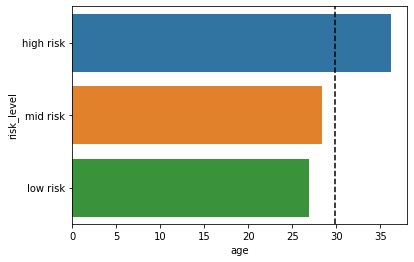

In [9]:
summary_stats_barplot(maternal_risk, np.mean, column=risk_level, value=age)

High risk patients appear to have a higher average age than mid and low risk<br>

#### Mean systolic bp by risk level

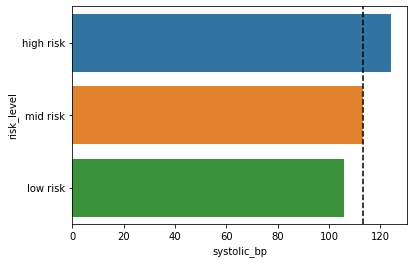

In [10]:
summary_stats_barplot(maternal_risk, np.mean, column=risk_level, value=systolic_bp)

The trend continues where high risk patients have an overall higher mean for each quantitative value examined<br>

#### Mean diastolic bp by risk level

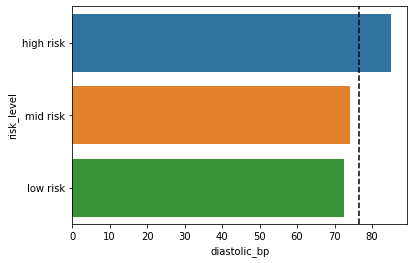

In [11]:
summary_stats_barplot(maternal_risk, np.mean, column=risk_level, value=diastolic_bp)

The trend based on risk level continues for diastolic bp

#### Mean blood sugar by risk level

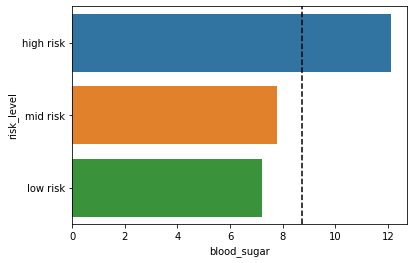

In [12]:
summary_stats_barplot(maternal_risk, np.mean, column=risk_level, value=blood_sugar)

Blood sugar levels are much larger in high risk groups than mid or low<br>
Comparatively high risk blood sugar levels are almost twice as high as low risk groups<br>
Further analysis of blood_sugar should be conducted

#### Mean body temp by risk level

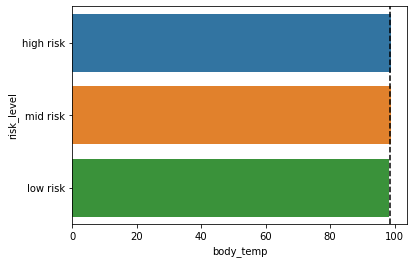

In [13]:
summary_stats_barplot(maternal_risk, np.mean, column=risk_level, value=body_temp)

Body temperature appears to be the healthy human average (98.6 degrees F)<br>
It is likely that patients tested did not have an illness which raised their body temp temperature at the time of recording

#### Mean heart rate by risk level

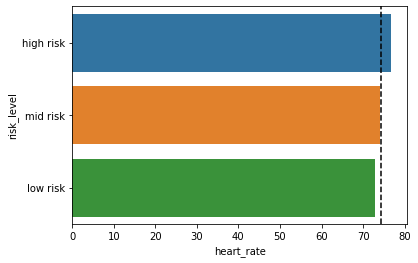

In [14]:
summary_stats_barplot(maternal_risk, np.mean, column=risk_level, value=heart_rate)

Slight elevation of heart rate in high risk patients

### Distributions by risk level

#### Distribution of age

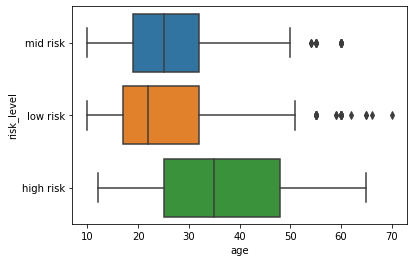

In [15]:
sorted_boxplot(maternal_risk, risk_level, age)

High risk IQR, median and range is much larger than mid and low risk<br>
Age ranges recorded appear to be past normal menopause age. Average menopause age is between 45 and 55 (nia.nih.gov)<br> 
Geriatric pregnacy is considered pregnancy at 35 years of age or older<br>
No clarification on how the age was recorded from the data source (UCI Machine Learning Repository)

#### Distribution of systolic and diastolic bp

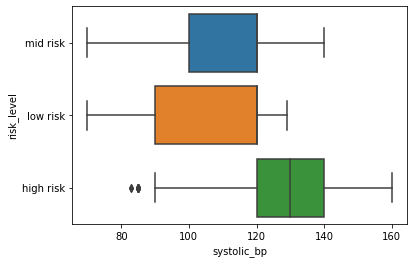

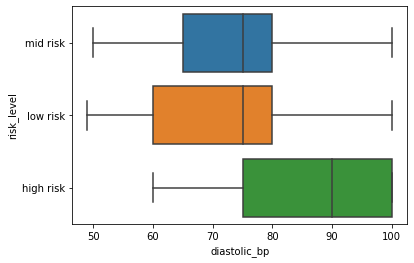

In [16]:
sorted_boxplot(maternal_risk, risk_level, systolic_bp)
sorted_boxplot(maternal_risk, risk_level, diastolic_bp)

Elevated systolic and diastolic bp is also an indicator of heart illness<br>
The median systolic blood pressure for high risk patients is ~130 which is hypertension stage 1<br>
The median diastolic blood pressure for high risk patients is ~90 which is hypertension stage 1<br>
Systolic/Diastolic blood pressure ranges in mmHg: (cdc.gov)<br>
Normal <= 120/80<br>
Elevated 120-129/80 or less<br>
Hypertension (Stage 1) 130-139/80-89<br>
Hypertension (Stage 2) >= 140/90<br>
Hypertension (Stage 3) > 180/120

#### Distribution of blood_sugar

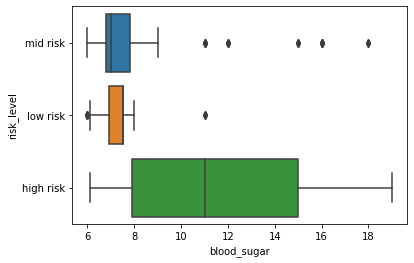

In [17]:
sorted_boxplot(maternal_risk, risk_level, blood_sugar)

Data source doesn't clarify if the blood sugar level was taken while fasting. We'll assume it wasn't since the the ranges of low risk blood sugar levels are between ~7-8 mmol/L which is non fasting.<br>
Median blood sugar levels of high risk group is ~11 mmol/L which is the upper limit for prediabetes<br>
Blood sugar levels non-fasting: (mayoclinic.org)<br>
Normal <= 7.8 mmol/L<br>
Prediabetes 7.8 - 11.0 mmol/L<br>
Diabetes > 11.1 mmol/L 2 hours after eating


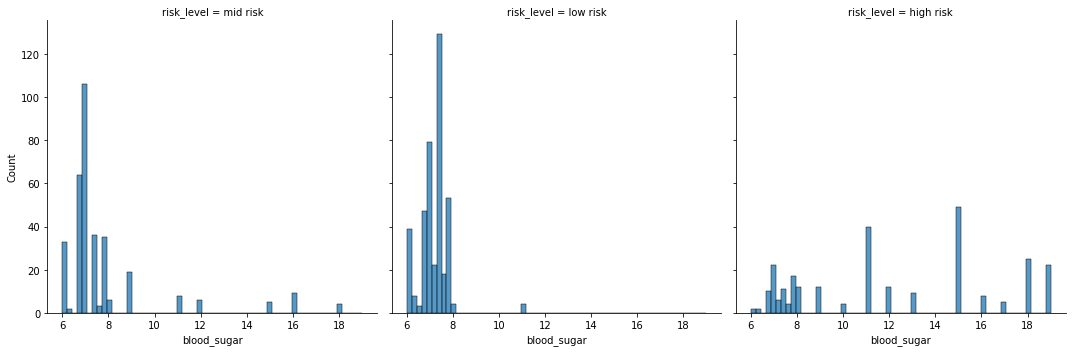

In [55]:
sns.displot(data=maternal_risk, x=blood_sugar, col=risk_level, col_wrap=3)

<AxesSubplot:xlabel='blood_sugar', ylabel='Count'>

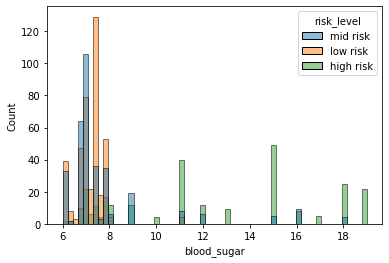

In [56]:
sns.histplot(data=maternal_risk, x=blood_sugar, hue=risk_level)

As risk level increases the distributions become further and further right skewed<br>
Blood sugar appears to be a strong indicator for high risk groups as low and mid risk group distributions mostly overlap between 6-8 mmol/L.<br>
Right skewed distributions would need to be transformed for statistical analysis.

#### Distribution of body temp

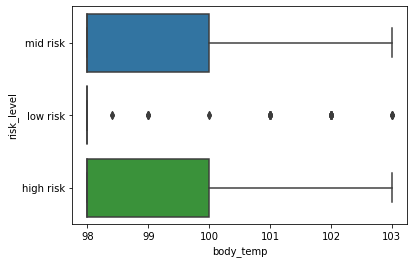

In [19]:
sorted_boxplot(maternal_risk, risk_level, body_temp)

Temperature indicative of a fever is 100.4 F or greater (https://www.hopkinsmedicine.org/health/conditions-and-diseases/fever)<br>
A majority of temperatures for each risk level is below the fever threshold. It is unlikely patients vitals were taken while sick<br>
Low variation in body temp makes it a weak feature for machine learning.

#### Distribution of heart rate

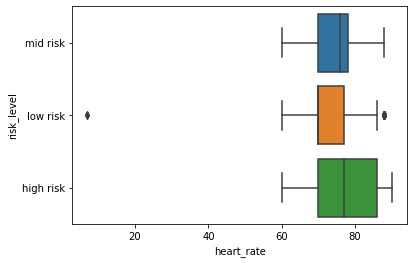

In [20]:
sorted_boxplot(maternal_risk, risk_level, heart_rate)

Outlier of 7 beats per minute is an incorrect measurement due to human error<br>
Elevated heart rates are assoicated with elevated blood pressure (Reule, S., & Drawz, P. E. (2012). Heart rate and blood pressure: any possible implications for management of hypertension?. Current hypertension reports, 14(6), 478–484. https://doi.org/10.1007/s11906-012-0306-3)<br>
There appears to be a trend of higher heart rates and higher blood pressure readings in high risk patients

## Bivariate Data Profiling
Identify trends/relationships between key variables<br>
Blood sugar vs bp, age, heart rate<br>
Heart rate vs bp<br>
An absolute value pearson correlation below 0.3 is considered weak<br>
An absolute value pearson correlation above 0.6 is considered strong

### Correlations

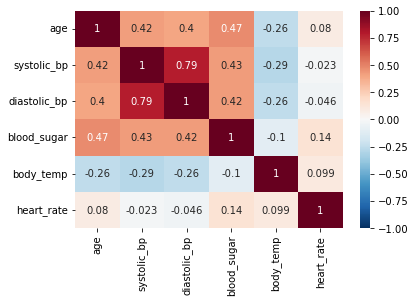

In [21]:
# Heatmap visualization to identify correlated variables
corr_heatmap(maternal_risk)

Blood sugar has a moderate correlation to age, systolic and diastolic bp. However, systolic and diastolic bp are strongly correlated to each other (colinear). Only one bp should be chosen for machine learning classification<br>
Heart rate appears to have no correlation to either systolic or diastolic bp despite being linked elevated blood pressure.

### Correlations by risk level

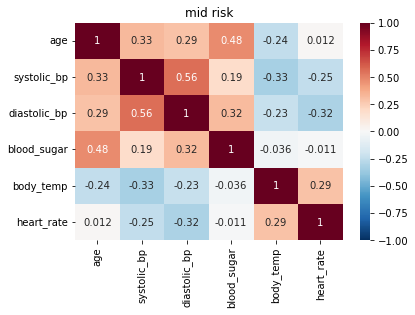

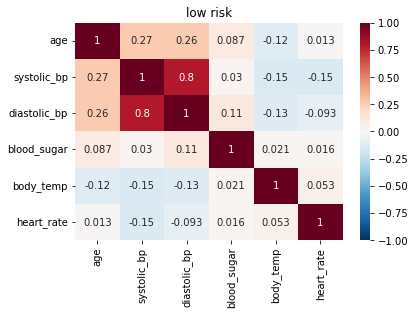

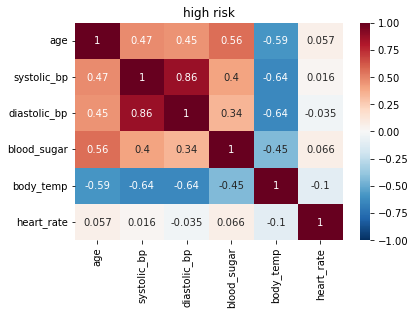

In [22]:
# Heatmap visualization to identify correlated variables
corr_heatmap_by_category(maternal_risk, risk_level)

#### Low risk correlation

Low risk has no longer has moderate correlation to blood sugar. As expected systolic and diastolic bp are strongly correlated<br>
It appears that having diabetes as a comorbidity is the distinguishing factor between the risk groups.

#### Mid risk correlation

Age and blood sugar correlation increases in the mid risk group. This appears to be due to older patients belonging to the mid and high risk groups compared to low risk<br>
Health declines as an adult ages which would increase the likelihood that older patients are classified as high risk (Yashin, A. I., Arbeev, K. G., Kulminski, A., Akushevich, I., Akushevich, L., & Ukraintseva, S. V. (2007). Health decline, aging and mortality: how are they related?. Biogerontology, 8(3), 291–302. https://doi.org/10.1007/s10522-006-9073-3).

#### High risk correlation

Similar trends to the mid risk group<br>
Body temp will be removed due to low variance for future machine learning classification

### Blood sugar vs systolic bp

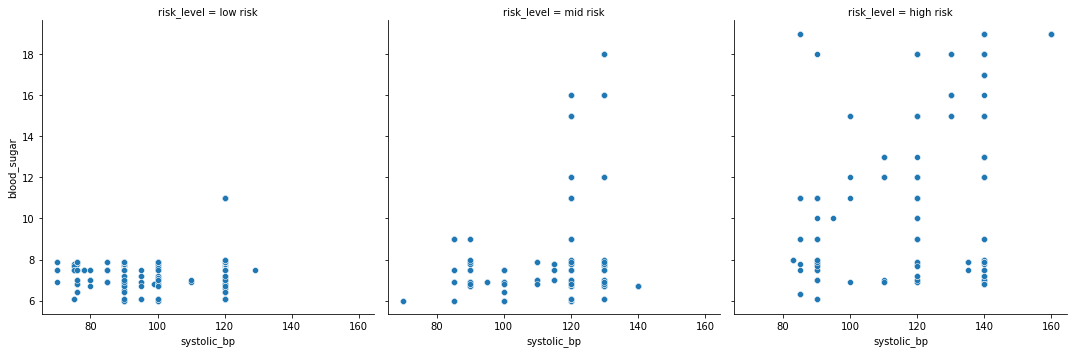

In [23]:
# Scatterplot visualization to identify trends by risk level
risk_order = ['low risk', 'mid risk', 'high risk']

sns.relplot(data=maternal_risk, x=systolic_bp, y=blood_sugar, col=risk_level, col_order=risk_order)

Systolic bp and blood sugar levels increase with increasing risk level (low > mid > high). A moderate positive correlation is seen only in the high risk group.

### Blood sugar vs age

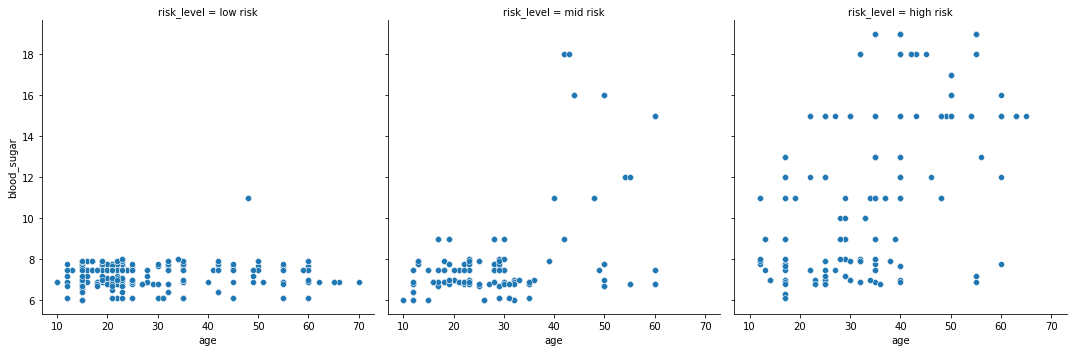

In [24]:
sns.relplot(data=maternal_risk, x=age, y=blood_sugar, col=risk_level, col_order=risk_order)

Similar to systolic bp a moderate positive correlation between blood sugar and age exists at the high risk level

### Blood sugar vs heart rate

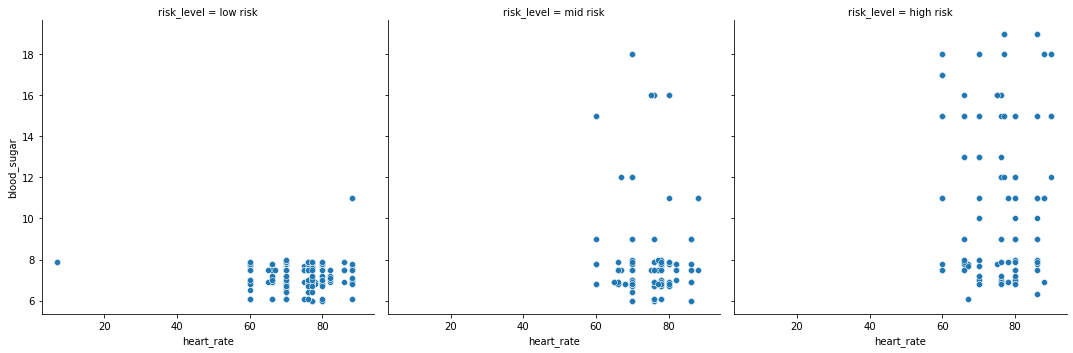

In [25]:
sns.relplot(data=maternal_risk, x=heart_rate, y=blood_sugar, col=risk_level, col_order=risk_order)

Heart rate remains in the same range between the three risk groups indicating weak to no correlation<br>
Blood sugar increases in the high risk group similar to the previous scatterplots

### Heart rate vs systolic bp

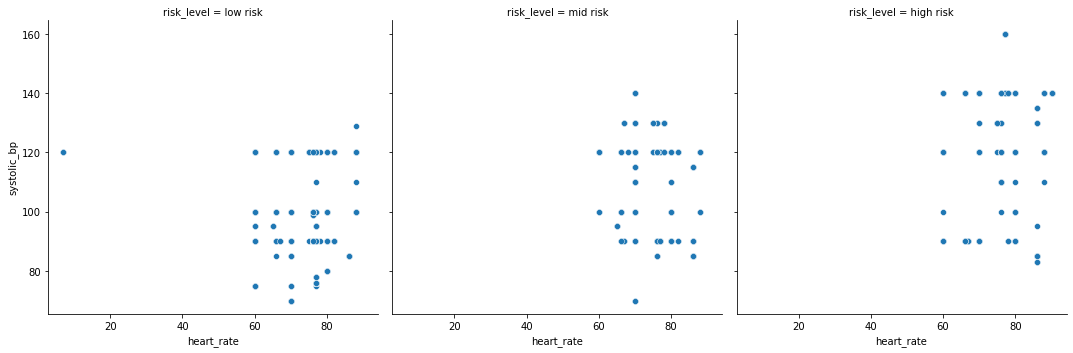

In [26]:
sns.relplot(data=maternal_risk, x=heart_rate, y=systolic_bp, col=risk_level, col_order=risk_order)

Heart rate range remains unchanged despite increasing systolic bp. Weak correlation similar to blood sugar vs heart rate. 

## Statistical Tests<br>
ANOVA Assumptions<br>
--- Taken from codecademy ---<br>
(1) All observations should be independently and randomly sampled<br>
(2) The standard deviations of the groups should be equal<br>
(3) The data should be normally distributed or the sample size should be large<br>
(4) The groups created by the categorical variable should be independent<br>
-------------------------------- <br>
Signifcance Threshold = 0.05<br>
Null Hypothesis - The tested variable means do not differ between risk levels<br>
Alt Hypothesis - Tested variables are not equal between risk levels

### Data Transformations / Assumption Checks

In [27]:
# Checking sample size of each risk category for assumption 3
maternal_risk.risk_level.value_counts()

low risk     406
mid risk     336
high risk    272
Name: risk_level, dtype: int64

#### Standard Deviations

##### Blood Sugar

In [28]:
# Calculating std to meet assumption 2
column_std(maternal_risk, risk_level, blood_sugar)

mid risk 2.2855108929417725
low risk 0.6455956579570131
high risk 4.173524640081767
ANOVA std ratio for blood_sugar is: 6.464610764714375


Blood Sugar is outside of the ideal ratio between 0.9 - 1.1

##### Age

In [29]:
# Calculating std to meet assumption 2
column_std(maternal_risk, risk_level, age)

mid risk 12.552659512575962
low risk 13.121660659805304
high risk 13.032205666100845
ANOVA std ratio for age is: 1.0453291309829031


Age is within ideal ratio

##### Systolic BP

In [30]:
# Calculating std to meet assumption 2
column_std(maternal_risk, risk_level, systolic_bp)

mid risk 14.983169899645691
low risk 15.894002109188493
high risk 20.227185024131106
ANOVA std ratio for systolic_bp is: 1.3499937035759983


Systolic bp is relatively close to the ideal ratio

#### Natural Log Transformations
Blood sugar and Systolic BP

In [57]:
# Transformation of chosen columns to prep for anova test
maternal_ln = ln_transformation(maternal_risk, [blood_sugar, systolic_bp])

0 records removed


In [62]:
# Recalculating std to check for an accurate transformation
column_std(maternal_ln, risk_level, systolic_bp)

mid risk 0.14176149842848065
low risk 0.15891071144938693
high risk 0.1760913596474828
ANOVA std ratio for systolic_bp is: 1.2421663258329745


In [33]:
column_std(maternal_ln, risk_level, blood_sugar)

mid risk 0.22334062799627016
low risk 0.08613575066925881
high risk 0.3567347104798671
ANOVA std ratio for blood_sugar is: 4.1415406228900835


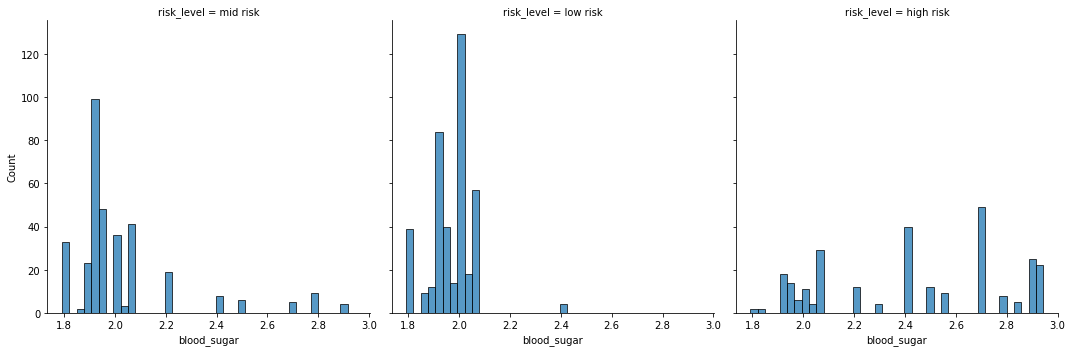

In [34]:
# Visualization of blood sugar distribution for assumption 3
sns.displot(data=maternal_ln, x=blood_sugar, col=risk_level, col_wrap=3)

#### ANOVA Tests

##### Blood Sugar
Assumption 2 was violated even after a ln transformation

In [35]:
#Anova test to determine if the pval is significant
anova_test(maternal_ln, risk_level, blood_sugar)

1.4810048233518435e-118


In [36]:
#Tukey's Range Test to determine which pairings are significant
tukeys_test(maternal_ln, risk_level, blood_sugar)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1   group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
high risk low risk  -0.4601    0.0 -0.5027 -0.4175   True
high risk mid risk  -0.4093    0.0 -0.4536  -0.365   True
 low risk mid risk   0.0508 0.0084  0.0107  0.0909   True
---------------------------------------------------------


All pairings are significant<br>
Blood sugar levels should be a strong feature in the machine learning model.

##### Age

In [63]:
#Anova test to determine if the pval is significant
anova_test(maternal_risk, risk_level, age)

6.829838408436776e-20


In [64]:
#Tukey's Range Test to determine which pairings are significant
tukeys_test(maternal_risk, risk_level, age)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1   group2  meandiff p-adj   lower    upper  reject
----------------------------------------------------------
high risk low risk  -9.3475    0.0 -11.7221 -6.9728   True
high risk mid risk  -7.8538    0.0 -10.3257  -5.382   True
 low risk mid risk   1.4936 0.2598  -0.7414  3.7287  False
----------------------------------------------------------


Risk level pairs that are not significantly different are: (pval >= 0.05)<br>
low risk - mid risk<br>
Consis

##### Systolic BP

In [39]:
#Anova test to determine if the pval is significant
anova_test(maternal_ln, risk_level, systolic_bp)

7.292193859488294e-39


In [40]:
#Tukey's Range Test to determine which pairings are significant
tukeys_test(maternal_ln, risk_level, systolic_bp)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1   group2  meandiff p-adj  lower    upper   reject
----------------------------------------------------------
high risk low risk -18.3279   0.0  -21.434 -15.2217   True
high risk mid risk -11.0401   0.0 -14.2735  -7.8067   True
 low risk mid risk   7.2878   0.0   4.3641  10.2114   True
----------------------------------------------------------


All pairings are significant<br>
Similar to blood sugar, systolic bp differences should be a strong feature for the ML model.

## Machine Learning
Select features and labels<br>
Normalize/transform the data<br>
Train test split the data

In [41]:
# Select features and outcomes for train_test_split
features, labels = extract_features(maternal_risk, risk_level)

Index(['age', 'systolic_bp', 'diastolic_bp', 'blood_sugar', 'body_temp',
       'heart_rate'],
      dtype='object')


In [42]:
# Normalize the data to prevent one or more features from having more importance than other features during model creation
scaled_features = scale_features(StandardScaler, features)

['age' 'systolic_bp' 'diastolic_bp' 'blood_sugar' 'body_temp' 'heart_rate']


### K Nearest Neighbors
---Assumptions Taken From Codecademy---<br>
(1) Nearby data points are similar to each other

#### Feature Selection

In [43]:
# SFS to finalize which features would improve the model's accuracy/effectiveness
sfs, num_of_features = sfs_feature_selection(KNeighborsClassifier,
                scaled_features,
                labels,
                k_features=3,
                forward=True,
                floating=True,
                scoring='accuracy')

# Set features equal to the features chosen by SFS to maximize KNN accuracy
features_sfs = selected_feature_data(sfs, scaled_features)

In [44]:
# Details about the feature selection for model evaluation
sfs_selection_details(sfs, features)

Column indexes chosen are: (0, 1, 3)
Column names chosen are: Index(['age', 'systolic_bp', 'blood_sugar'], dtype='object')
Model score is: 0.7199239135736233


#### Model Testing

In [45]:
#Train test split to judge effectiveness of model when scoring with test data
X_train, X_test, y_train, y_test = train_test_split(features_sfs, labels, train_size=0.8, random_state=7)

In [46]:
# Fit the model with training data and use test data to calculate accuracy of the model
classifier = KNC_evaluation(X_train, X_test, y_train, y_test, n_neighbors=3)

Accuracy score of training data: 0.8495684340320592
Accuracy score of test data: 0.7142857142857143


Overfitting is occuring due to training score > test score.<br>
To improve the model hyperparameters need to be tested. Optimal combinations will improve the model's ability to generalize unknown data.

#### Hyperparameter Tuning (k_neighbors)
Testing all possible n_neighbors values based on number of features selected<br>
Also testing both weight types to find the optimal combination of hyperparameters

In [65]:
# All possible n_neighbor values to tune k_neighbors
k_array = [*range(1, num_of_features + 1)]
print(f"Values of n_neighbors being tested: {k_array}")

# Dict to pass in to determine which values each hyperparameter will be tried in the model
tuned_parameters = {'n_neighbors': k_array, 'weights': ['uniform', 'distance']}

Values of n_neighbors being tested: [1, 2, 3]


In [48]:
# GridSearchCV to find the optimal n_neighbors based on model accuracy
best_parameters = optimal_hyperparameters(KNeighborsClassifier, 
                                        tuned_parameters, 
                                        X_train, 
                                        y_train, 
                                        scoring='accuracy')

KNeighborsClassifier(n_neighbors=3, weights='distance')
Highest model make_scorer(accuracy_score) is: 0.7620162084374764


#### Model Testing post GridSearchCV

In [49]:
tuned_classifier = KNC_evaluation(X_train, X_test, y_train, y_test, **best_parameters)

Accuracy score of training data: 0.8828606658446363
Accuracy score of test data: 0.8078817733990148


Test accuracy score improvement compared to feature selected only model<br> 
Although there is still some overfitting it is acceptable for the data available.